<a href="https://colab.research.google.com/github/glwat/Durham_Masters/blob/main/Autocorrelation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the aggregated dataset from the google drive folder. Return info on the dataset variables.

In [2]:
# ============================================
# Codeblock B — Load Clean Aggregated Dataset
# ============================================

import pandas as pd

# Path to your saved file in Google Drive
file_path = "/content/drive/MyDrive/Masters_Colab_Data/Master_Rockfall_2021.xlsx"

# Load the dataset
df_agg = pd.read_excel(file_path)

print("Dataset loaded successfully. Shape:", df_agg.shape)
df_agg.info()

Dataset loaded successfully. Shape: (8376, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8376 entries, 0 to 8375
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    8376 non-null   int64         
 1   Datetime              8376 non-null   datetime64[ns]
 2   Gap_Rockfall          5193 non-null   object        
 3   Gap_hours             258 non-null    float64       
 4   Rockfall_Volume       8376 non-null   float64       
 5   Volume_Error          8376 non-null   float64       
 6   Rockfall_Event_Count  8376 non-null   int64         
 7   Total_Rainfall        8376 non-null   float64       
 8   Air_Temp              8376 non-null   float64       
 9   Relative_Humidity     8376 non-null   float64       
 10  Hourly_Rainfall       8330 non-null   float64       
 11  Thermal_image_name    4071 non-null   object        
 12  TA                    4071 no

Ensure the DateTime column is in datetime format. Create a complete hourly index from the first to last observation in time. Compare the create index with the hourly timestamps present in the dataset to determine missing hours. Compute the percentage of total hours missing in the dataset.

In [4]:
# ============================================================
# Codeblock E — Count Missing Hourly Timestamps + Percentage
# ============================================================

# Ensure Datetime column is in datetime format
df_agg['Datetime'] = pd.to_datetime(df_agg['Datetime'])

# Create a complete hourly index from min to max timestamp
full_range = pd.date_range(
    start=df_agg['Datetime'].min(),
    end=df_agg['Datetime'].max(),
    freq='H'
)

# Extract the timestamps actually present
existing_times = pd.to_datetime(df_agg['Datetime']).sort_values()

# Identify missing timestamps
missing_times = full_range.difference(existing_times)

# Compute percentage missing
total_expected = len(full_range)
total_present = len(existing_times)
total_missing = len(missing_times)
percent_missing = (total_missing / total_expected) * 100

print("First timestamp in dataset:", df_agg['Datetime'].min())
print("Last timestamp in dataset:", df_agg['Datetime'].max())
print("Total expected hourly timestamps:", total_expected)
print("Actual timestamps present:", total_present)
print("Missing hourly timestamps:", total_missing)
print(f"Percentage of missing hours: {percent_missing:.2f}%")

# Uncomment below to display the missing timestamps
# missing_times

First timestamp in dataset: 2021-01-01 01:00:00
Last timestamp in dataset: 2021-12-31 23:00:00
Total expected hourly timestamps: 8759
Actual timestamps present: 8376
Missing hourly timestamps: 383
Percentage of missing hours: 4.37%


/tmp/ipython-input-3366475235.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


Essentially this codeblock defines two functions, one for definding the command to draw the autocorrelation plot and another for defining the adapted autocorrelation command. As our data contains gaps in the timeseries, we cannot use standard autocorrelation (this computed on adjacent value). Instead we use the DateTime column to bin values that fall within the hourly lag (i.e. all observations pairs that are 3hrs apart are binned into the 3hr lag bin). Covariance is the calcaulated on binned values. This essentially removes the issues of missing values. There is some fancy code in here to prevent the generation of a large matrix, storing the time differences between all observation pairs (as this would be over 1 million values).

In [9]:
# ============================================================
# Codeblock F — Efficient Time‑Difference Binned Autocorrelation
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def time_difference_acf(df, value_col, time_col='Datetime',
                        max_lag_hours=48, bin_width_hours=1):
    """
    Efficient autocorrelation for irregular time series using
    time-difference binning without pairwise matrices.
    """

    # Extract and clean data
    t = pd.to_datetime(df[time_col]).values
    x = df[value_col].astype(float).values

    valid = ~np.isnan(x)
    t = t[valid]
    x = x[valid]

    # Convert timestamps to hours since start
    t_hours = (t - t.min()).astype('timedelta64[s]').astype(float) / 3600.0

    # Prepare bins
    bins = np.arange(0, max_lag_hours + bin_width_hours, bin_width_hours)
    bin_centres = (bins[:-1] + bins[1:]) / 2

    # Precompute mean and variance
    x_mean = np.mean(x)
    x_var = np.var(x)

    acf_vals = []

    # Loop over lag bins
    for lag_min, lag_max in zip(bins[:-1], bins[1:]):

        cov_values = []

        # For each point, find points within the lag window
        for i in range(len(t_hours)):
            # Compute time differences from t[i]
            diffs = t_hours - t_hours[i]

            # Select values in the lag window
            mask = (diffs >= lag_min) & (diffs < lag_max)

            if np.any(mask):
                cov_values.extend((x[mask] - x_mean) * (x[i] - x_mean))

        if len(cov_values) > 0:
            acf_vals.append(np.mean(cov_values) / x_var)
        else:
            acf_vals.append(np.nan)

    return bin_centres, np.array(acf_vals)


def plot_time_difference_acf(df, value_col, time_col='Datetime',
                             max_lag_hours=24, bin_width_hours=1):

    # Compute ACF
    lags, acf_vals = time_difference_acf(
        df, value_col, time_col, max_lag_hours, bin_width_hours
    )

    # Create figure
    plt.figure(figsize=(8.3, 5.8))

    # Stem plot
    markerline, stemlines, baseline = plt.stem(lags, acf_vals)

    # Remove markers
    markerline.set_visible(False)

    # Make stems black
    plt.setp(stemlines, color="black")

    # Labels and formatting
    plt.xlabel("Lag (hours)", fontsize=12)
    plt.ylabel("Autocorrelation", fontsize=12)
    plt.title(f"Time‑Difference Autocorrelation — {value_col}", fontsize=14)
    plt.grid(alpha=0.6)

    plt.show()

Command execution to draw plots.

Running time‑difference ACF for the following variables:
 - Hourly_Rainfall
 - Air_Temp
 - Total_Rainfall
 - Relative_Humidity
 - Tmean
 - Tmax
 - Ref_Mean
 - Ref_Max

=== Time‑Difference ACF for Hourly_Rainfall ===


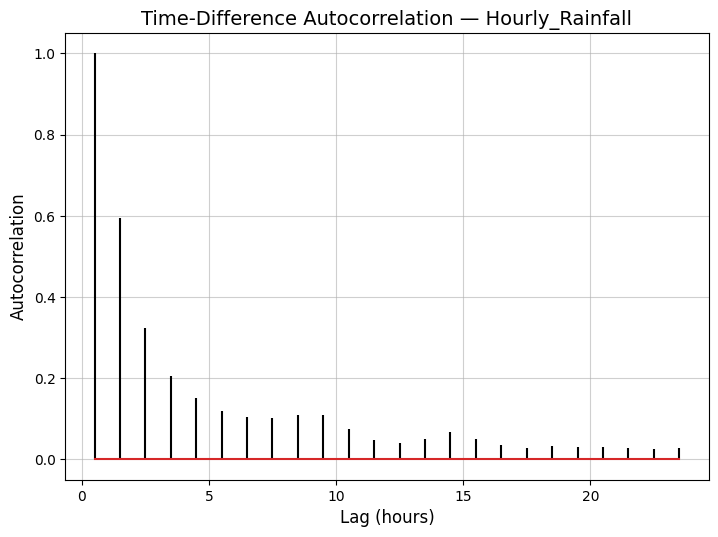


=== Time‑Difference ACF for Air_Temp ===


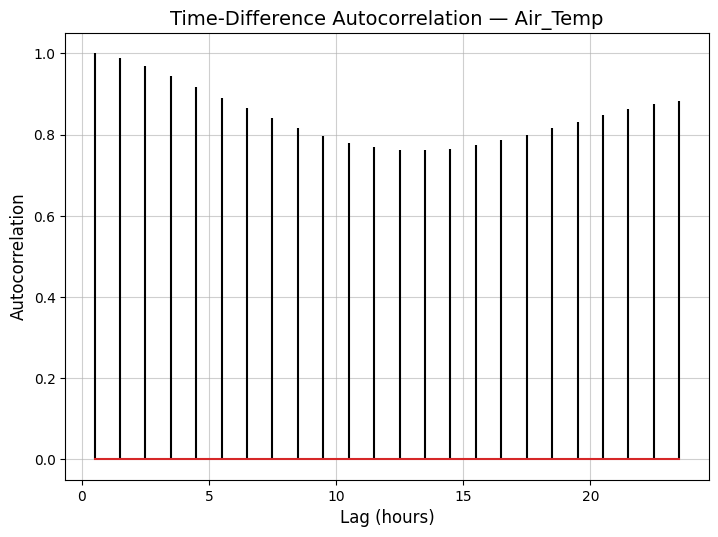


=== Time‑Difference ACF for Total_Rainfall ===


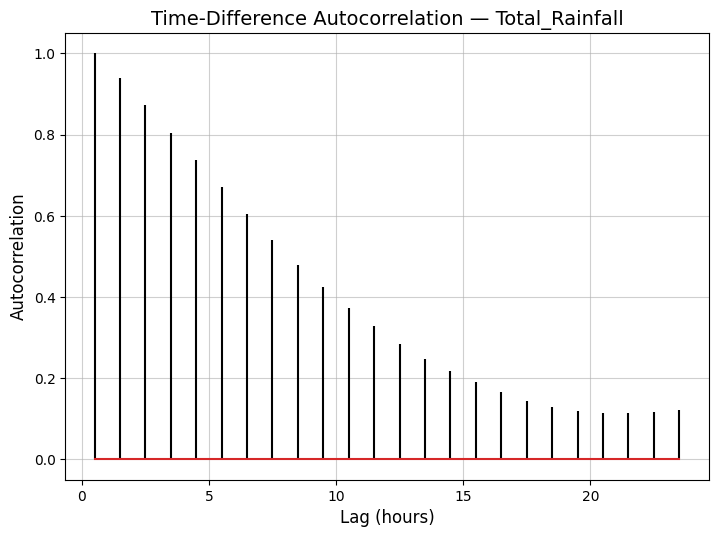


=== Time‑Difference ACF for Relative_Humidity ===


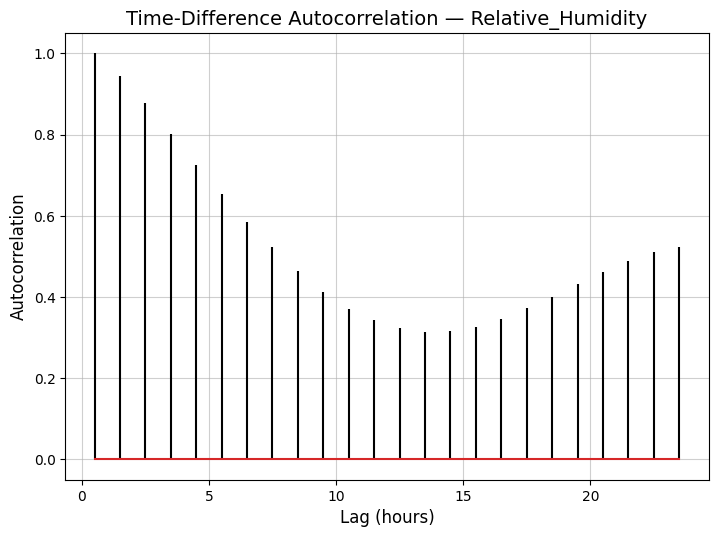


=== Time‑Difference ACF for Tmean ===


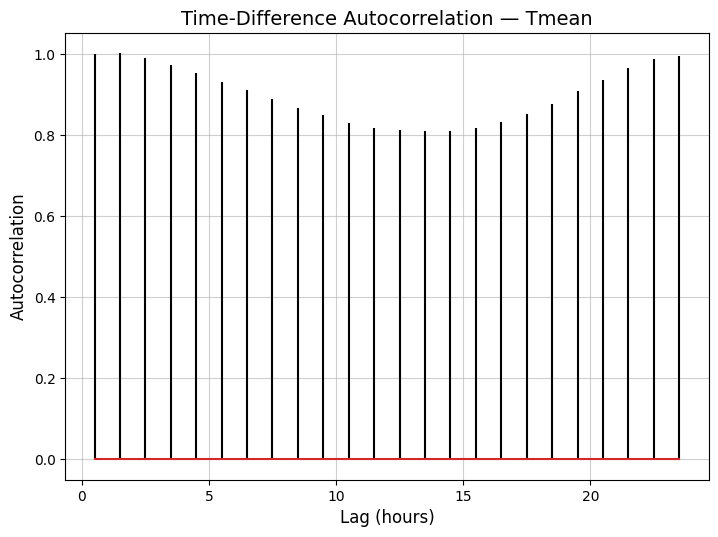


=== Time‑Difference ACF for Tmax ===


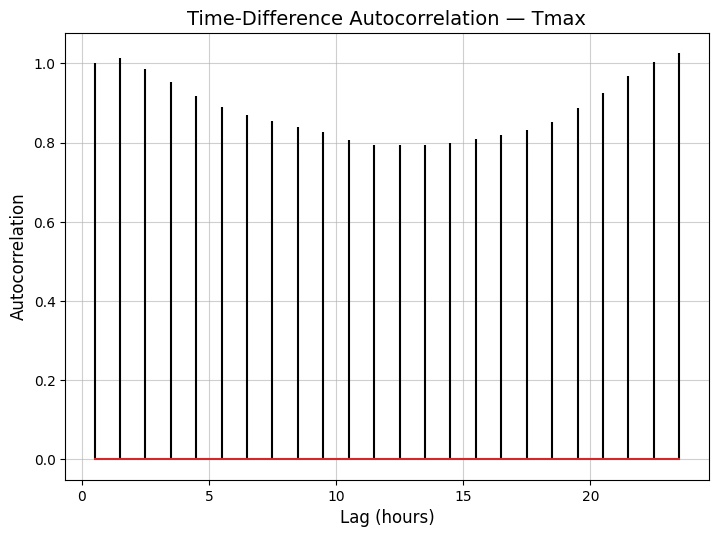


=== Time‑Difference ACF for Ref_Mean ===


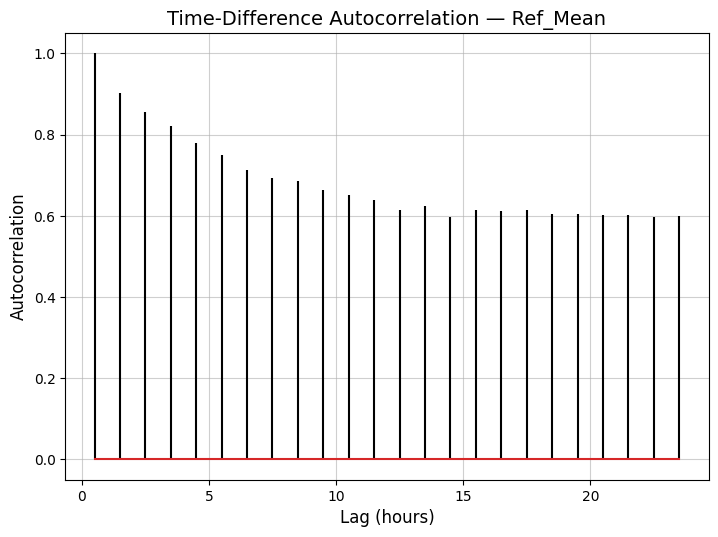


=== Time‑Difference ACF for Ref_Max ===


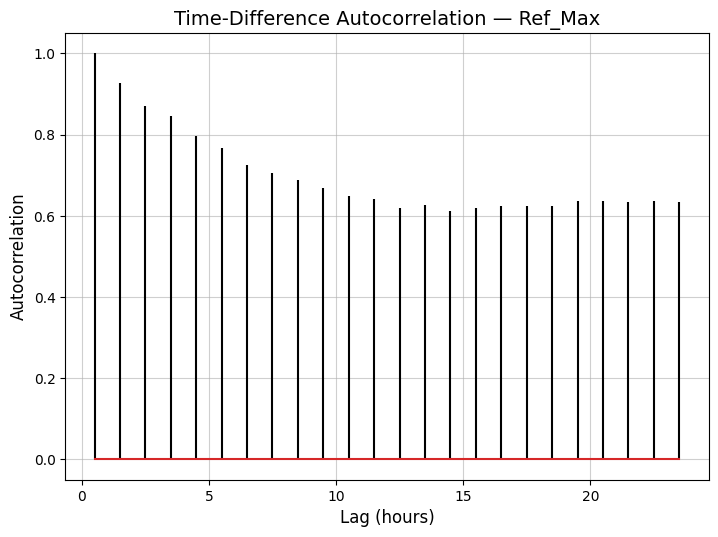

In [12]:
# ============================================================
# Codeblock G — Execute Time‑Difference ACF for Selected Variables
# ============================================================

# Choose which environmental variables to analyse
# Update this list based on your actual column names
variables_to_analyse = [
    'Hourly_Rainfall',
    'Air_Temp',
    'Total_Rainfall',
    'Relative_Humidity',
    'Tmean',
    'Tmax',
    'Ref_Mean',
    'Ref_Max'
    # Add or remove variables as needed
]

print("Running time‑difference ACF for the following variables:")
for v in variables_to_analyse:
    print(" -", v)

# Generate ACF plots for each variable
for var in variables_to_analyse:
    print(f"\n=== Time‑Difference ACF for {var} ===")
    plot_time_difference_acf(
        df_agg,
        value_col=var,
        time_col='Datetime',
        max_lag_hours=24,
        bin_width_hours=1
    )

Repeat of Codeblock G for Rockfall Variables

Running time‑difference ACF for the following variables:
 - Rockfall_Event_Count
 - Rockfall_Volume

=== Time‑Difference ACF for Rockfall_Event_Count ===


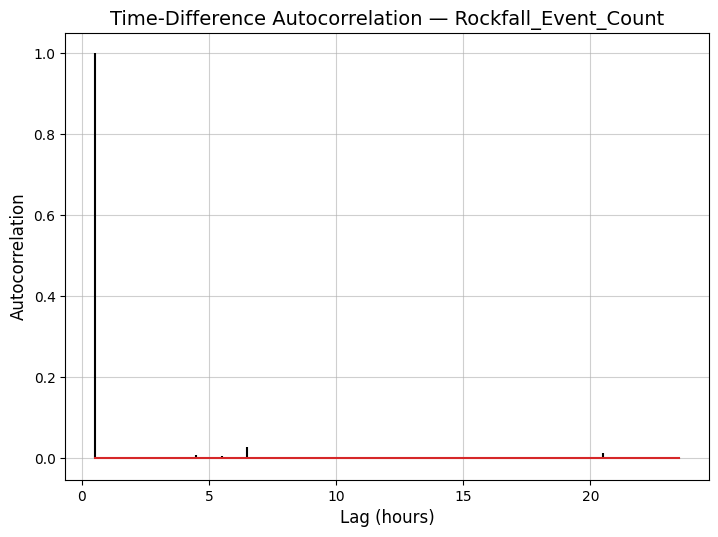


=== Time‑Difference ACF for Rockfall_Volume ===


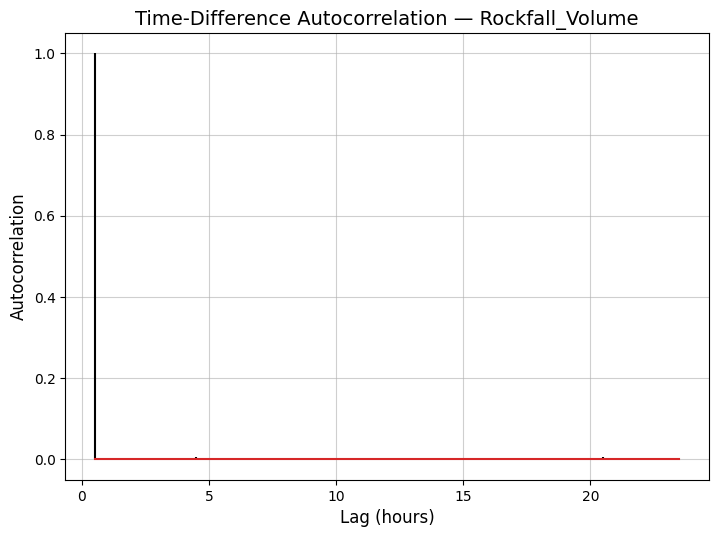

In [14]:
# ============================================================
# Codeblock G — Execute Time‑Difference ACF for Selected Variables
# ============================================================

# Choose which environmental variables to analyse
# Update this list based on your actual column names
variables_to_analyse = [
    'Rockfall_Event_Count',
    'Rockfall_Volume'
    # Add or remove variables as needed
]

print("Running time‑difference ACF for the following variables:")
for v in variables_to_analyse:
    print(" -", v)

# Generate ACF plots for each variable
for var in variables_to_analyse:
    print(f"\n=== Time‑Difference ACF for {var} ===")
    plot_time_difference_acf(
        df_agg,
        value_col=var,
        time_col='Datetime',
        max_lag_hours=24,
        bin_width_hours=1
    )

Partial Autocorrelation (accounting for data gaps) using Yule-Walker Equation

In [15]:
# ============================================================
# Codeblock H — Partial Autocorrelation (Irregular Time Series)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def irregular_pacf_from_acf(acf_vals):
    """
    Compute partial autocorrelation from binned ACF values
    using the Yule–Walker equations.
    """

    n = len(acf_vals)
    pacf = np.zeros(n)

    # PACF at lag 0 is always 1
    pacf[0] = 1.0

    for k in range(1, n):
        # Build the Toeplitz matrix for Yule–Walker
        R = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                R[i, j] = acf_vals[abs(i - j)]

        r = acf_vals[1:k+1]

        # Solve for AR coefficients
        try:
            phi = np.linalg.solve(R, r)
            pacf[k] = phi[-1]  # last coefficient = PACF at lag k
        except np.linalg.LinAlgError:
            pacf[k] = np.nan

    return pacf


def plot_irregular_pacf(df, value_col, time_col='DateTime',
                        max_lag_hours=24, bin_width_hours=1):

    # Compute irregular ACF first
    lags, acf_vals = time_difference_acf(
        df, value_col, time_col, max_lag_hours, bin_width_hours
    )

    # Compute PACF from ACF
    pacf_vals = irregular_pacf_from_acf(acf_vals)

    # Plot
    plt.figure(figsize=(8.3, 5.8))
    markerline, stemlines, baseline = plt.stem(lags, pacf_vals)

    # Remove markers
    markerline.set_visible(False)

    # Make stems black
    plt.setp(stemlines, color="black")

    # Leave baseline as default (per your instruction)

    # Labels and formatting
    plt.xlabel("Lag (hours)", fontsize=12)
    plt.ylabel("Partial Autocorrelation", fontsize=12)
    plt.title(f"Partial Autocorrelation — {value_col}", fontsize=14)
    plt.grid(alpha=0.6)

    plt.show()

Execution code for Partial Autocorrelation:

Running irregular‑time PACF for the following variables:
 - Hourly_Rainfall
 - Air_Temp
 - Total_Rainfall
 - Relative_Humidity
 - Tmean
 - Tmax
 - Ref_Mean
 - Ref_Max

=== Irregular‑Time PACF for Hourly_Rainfall ===


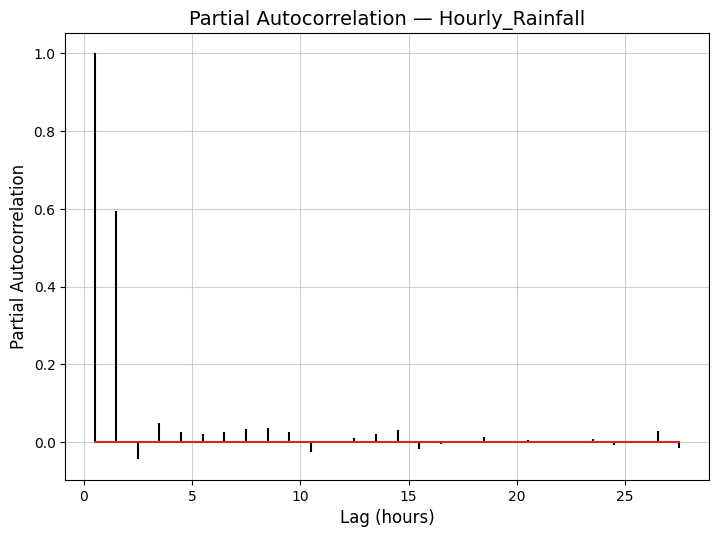


=== Irregular‑Time PACF for Air_Temp ===


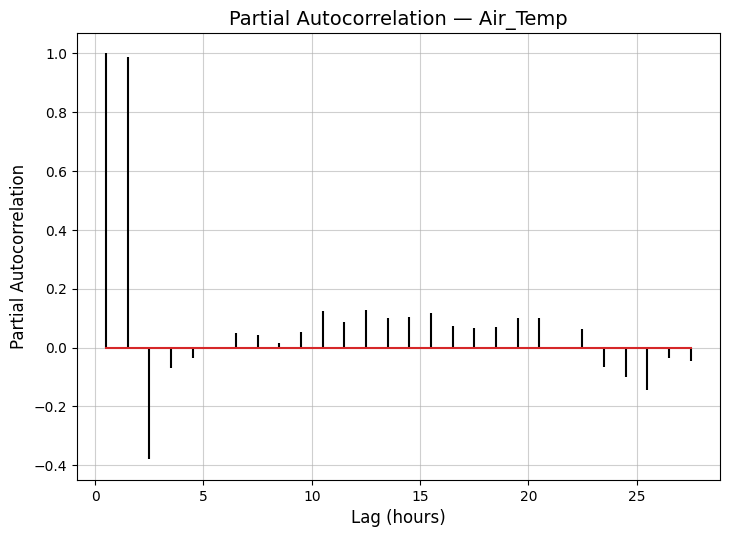


=== Irregular‑Time PACF for Total_Rainfall ===


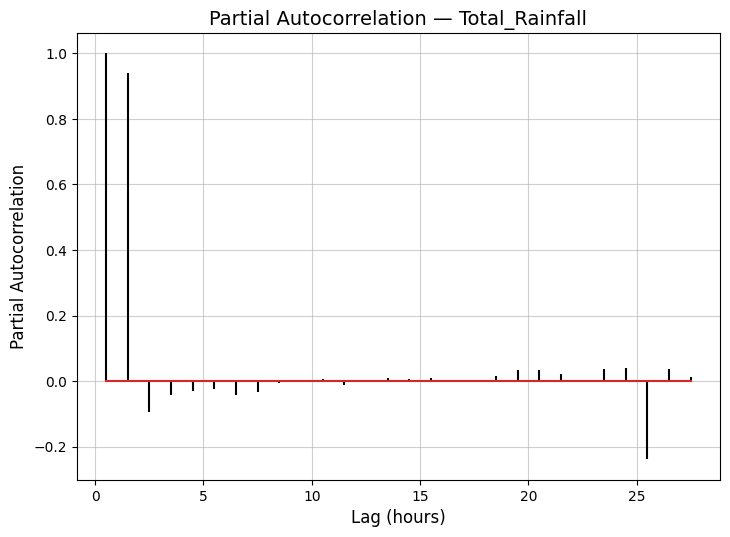


=== Irregular‑Time PACF for Relative_Humidity ===


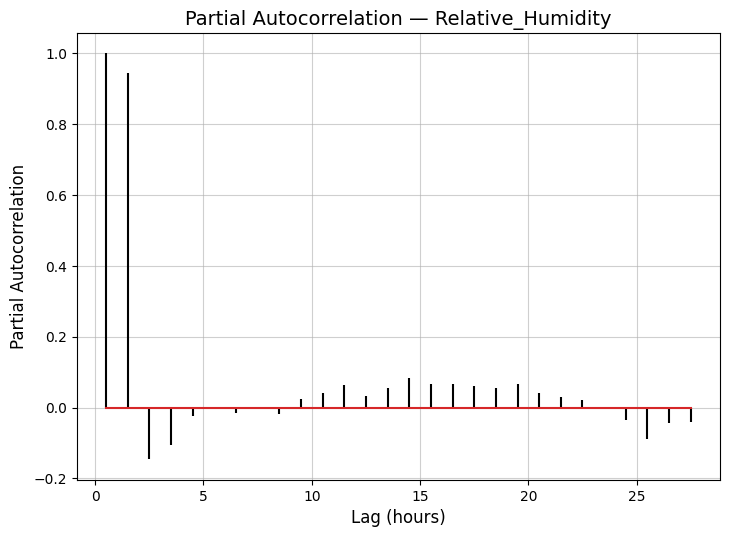


=== Irregular‑Time PACF for Tmean ===


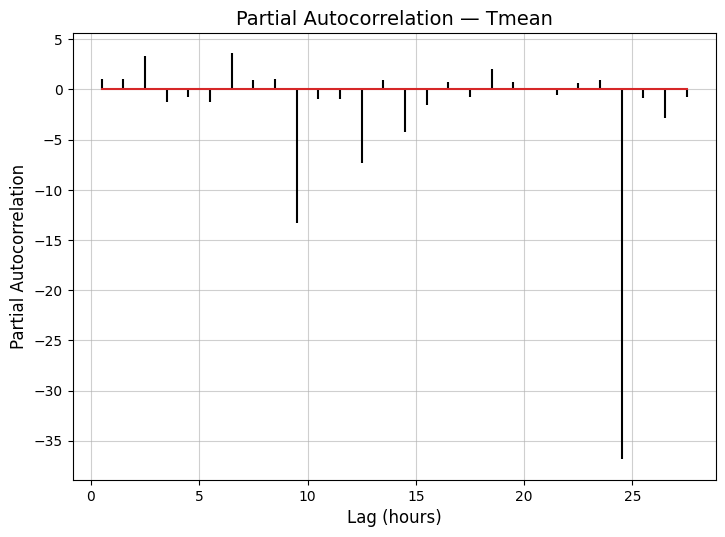


=== Irregular‑Time PACF for Tmax ===


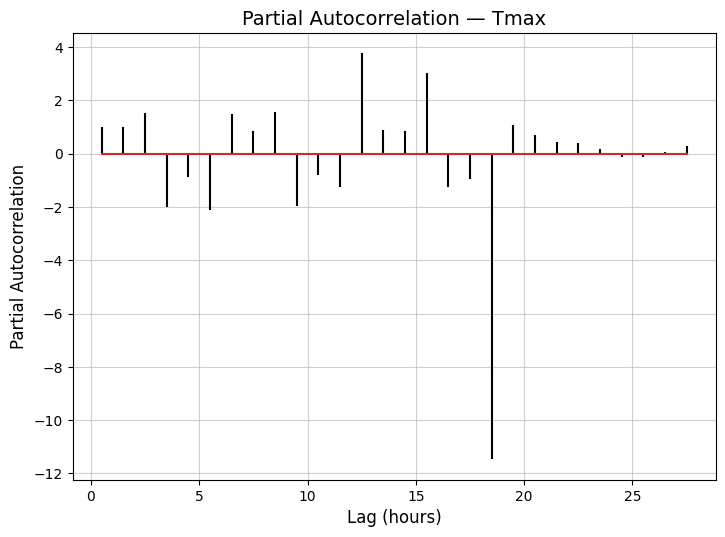


=== Irregular‑Time PACF for Ref_Mean ===


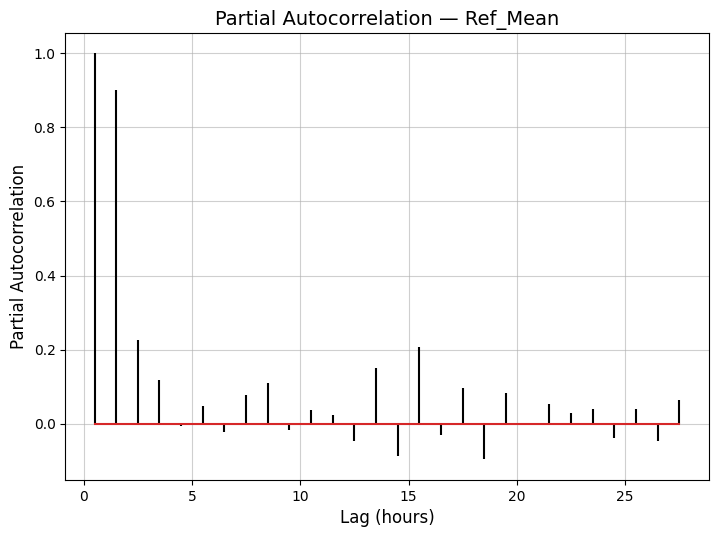


=== Irregular‑Time PACF for Ref_Max ===


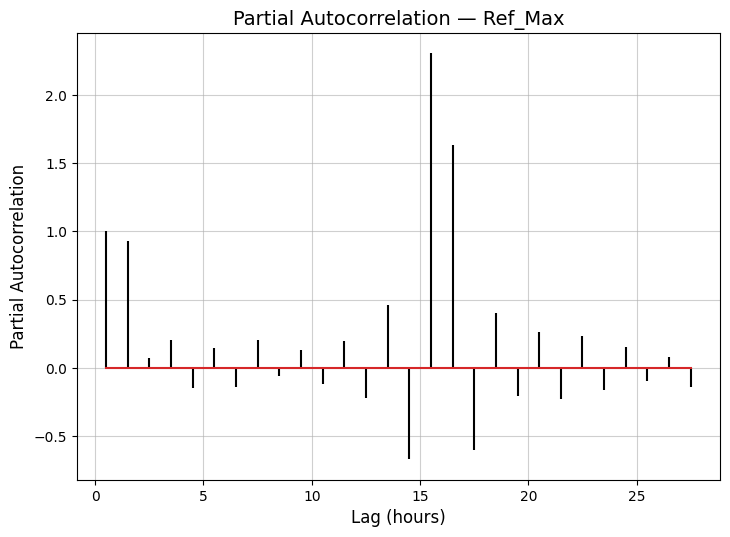

In [17]:
# ============================================================
# Codeblock I — Execute Irregular‑Time PACF for Selected Variables
# ============================================================

# Choose which environmental variables to analyse
variables_to_analyse = [
    'Hourly_Rainfall',
    'Air_Temp',
    'Total_Rainfall',
    'Relative_Humidity',
    'Tmean',
    'Tmax',
    'Ref_Mean',
    'Ref_Max'
    # Add or remove variables as needed
]

print("Running irregular‑time PACF for the following variables:")
for v in variables_to_analyse:
    print(" -", v)

# Generate PACF plots for each variable
for var in variables_to_analyse:
    print(f"\n=== Irregular‑Time PACF for {var} ===")
    plot_irregular_pacf(
        df_agg,
        value_col=var,
        time_col='Datetime',
        max_lag_hours=28,
        bin_width_hours=1
    )

Repeat of codeblock I for Rockfall Variables

Running irregular‑time PACF for the following variables:
 - Rockfall_Event_Count
 - Rockfall_Volume

=== Irregular‑Time PACF for Rockfall_Event_Count ===


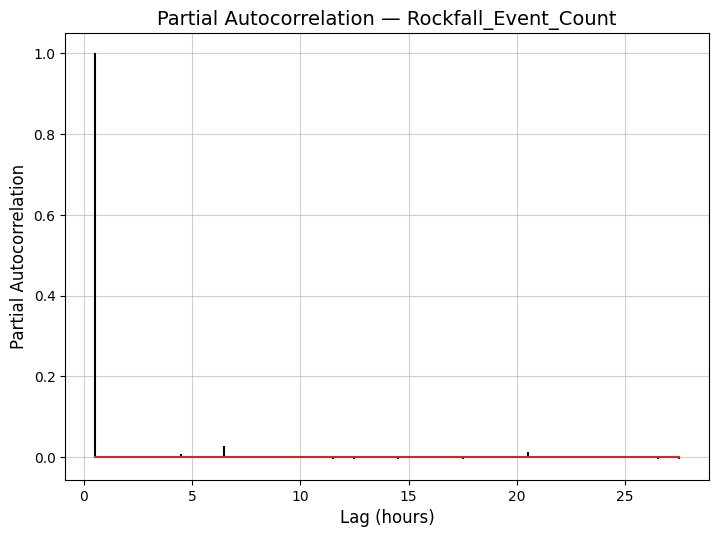


=== Irregular‑Time PACF for Rockfall_Volume ===


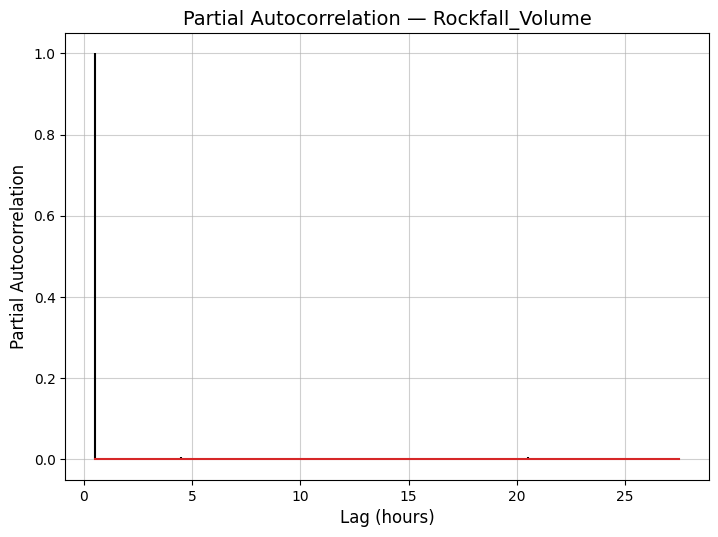

In [18]:
# ============================================================
# Codeblock I — Execute Irregular‑Time PACF for Selected Variables
# ============================================================

# Choose which environmental variables to analyse
variables_to_analyse = [
    'Rockfall_Event_Count',
    'Rockfall_Volume'
]

print("Running irregular‑time PACF for the following variables:")
for v in variables_to_analyse:
    print(" -", v)

# Generate PACF plots for each variable
for var in variables_to_analyse:
    print(f"\n=== Irregular‑Time PACF for {var} ===")
    plot_irregular_pacf(
        df_agg,
        value_col=var,
        time_col='Datetime',
        max_lag_hours=28,
        bin_width_hours=1
    )

# Cross- Correlation analysis

In [21]:
# ============================================================
# Codeblock J — Irregular‑Time Cross‑Correlation Function
# ============================================================

import numpy as np
import pandas as pd

def time_difference_xcf(df, x_col, y_col, time_col='Datetime',
                        max_lag_hours=48, bin_width_hours=1):
    """
    Compute cross-correlation between two irregular time series X(t) and Y(t)
    using time-difference binning.

    X = environmental variable
    Y = rockfall variable (event count or volume)
    """

    # Extract and clean data
    t = pd.to_datetime(df[time_col]).values
    x = df[x_col].astype(float).values
    y = df[y_col].astype(float).values

    valid = ~np.isnan(x) & ~np.isnan(y)
    t = t[valid]
    x = x[valid]
    y = y[valid]

    # Convert timestamps to hours since start
    t_hours = (t - t.min()).astype('timedelta64[s]').astype(float) / 3600.0

    # Prepare lag bins
    bins = np.arange(-max_lag_hours, max_lag_hours + bin_width_hours, bin_width_hours)
    bin_centres = (bins[:-1] + bins[1:]) / 2

    # Precompute means and variances
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_var, y_var = np.var(x), np.var(y)

    xcf_vals = []

    # Loop through lag bins
    for lag_min, lag_max in zip(bins[:-1], bins[1:]):

        cov_values = []

        for i in range(len(t_hours)):
            diffs = t_hours - t_hours[i]  # positive = X leads Y

            mask = (diffs >= lag_min) & (diffs < lag_max)

            if np.any(mask):
                cov_values.extend((x[i] - x_mean) * (y[mask] - y_mean))

        if len(cov_values) > 0:
            xcf_vals.append(np.mean(cov_values) / np.sqrt(x_var * y_var))
        else:
            xcf_vals.append(np.nan)

    return bin_centres, np.array(xcf_vals)

In [22]:
def plot_time_difference_xcf(df, x_col, y_col, time_col='Datetime',
                             max_lag_hours=48, bin_width_hours=1):

    # Compute irregular‑time XCF
    lags, xcf_vals = time_difference_xcf(
        df, x_col, y_col, time_col, max_lag_hours, bin_width_hours
    )

    # Plot
    plt.figure(figsize=(8.3, 5.8))
    markerline, stemlines, baseline = plt.stem(lags, xcf_vals)

    # Remove markers
    markerline.set_visible(False)

    # Make stems black
    plt.setp(stemlines, color="black")

    # Baseline stays default (per your instruction)

    # Add vertical zero‑lag reference line
    plt.axvline(0, color='k', linestyle='--', alpha=0.7)

    # Labels and formatting
    plt.xlabel("Lag (hours)", fontsize=12)
    plt.ylabel("Cross‑Correlation", fontsize=12)
    plt.title(f"XCF: {x_col} → {y_col}", fontsize=14)
    plt.grid(alpha=0.6)

    plt.show()

Running irregular‑time cross‑correlation for:
 - Hourly_Rainfall → Rockfall_Event_Count
 - Hourly_Rainfall → Rockfall_Volume
 - Air_Temp → Rockfall_Event_Count
 - Air_Temp → Rockfall_Volume
 - Total_Rainfall → Rockfall_Event_Count
 - Total_Rainfall → Rockfall_Volume
 - Relative_Humidity → Rockfall_Event_Count
 - Relative_Humidity → Rockfall_Volume
 - Tmean → Rockfall_Event_Count
 - Tmean → Rockfall_Volume
 - Tmax → Rockfall_Event_Count
 - Tmax → Rockfall_Volume
 - Ref_Mean → Rockfall_Event_Count
 - Ref_Mean → Rockfall_Volume
 - Ref_Max → Rockfall_Event_Count
 - Ref_Max → Rockfall_Volume

=== XCF: Hourly_Rainfall → Rockfall_Event_Count ===


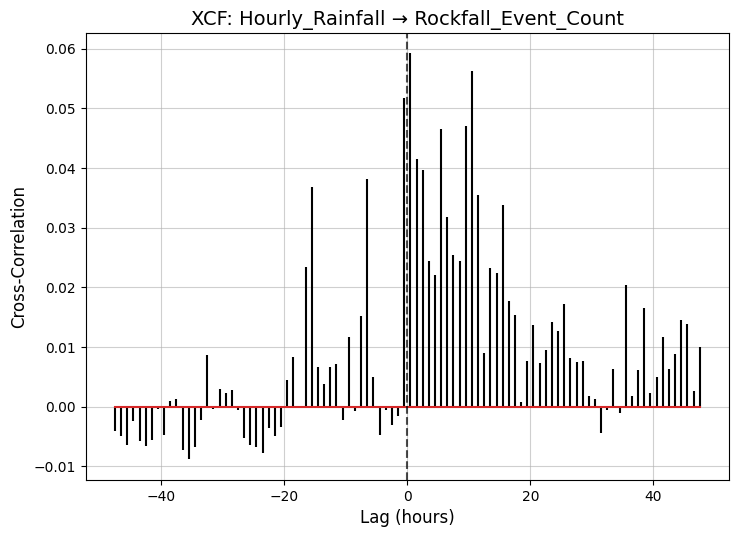


=== XCF: Hourly_Rainfall → Rockfall_Volume ===


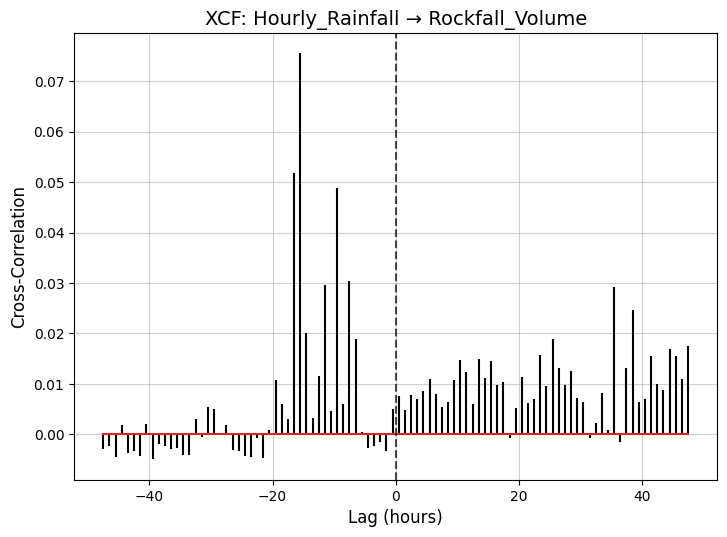


=== XCF: Air_Temp → Rockfall_Event_Count ===


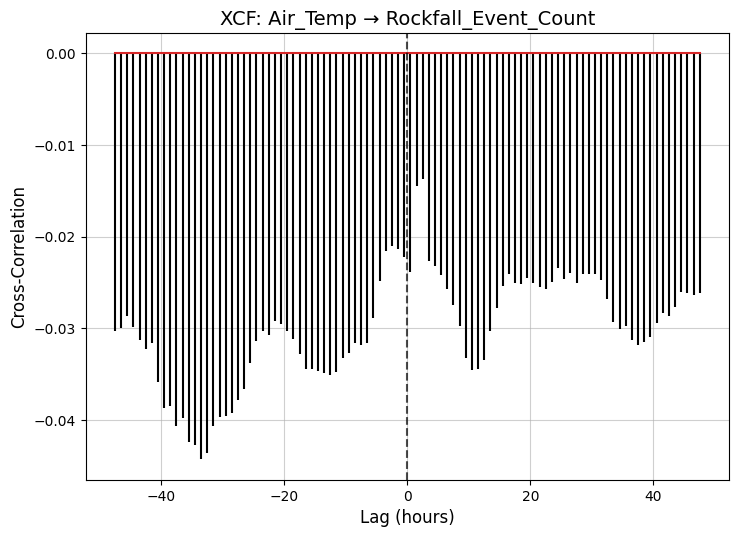


=== XCF: Air_Temp → Rockfall_Volume ===


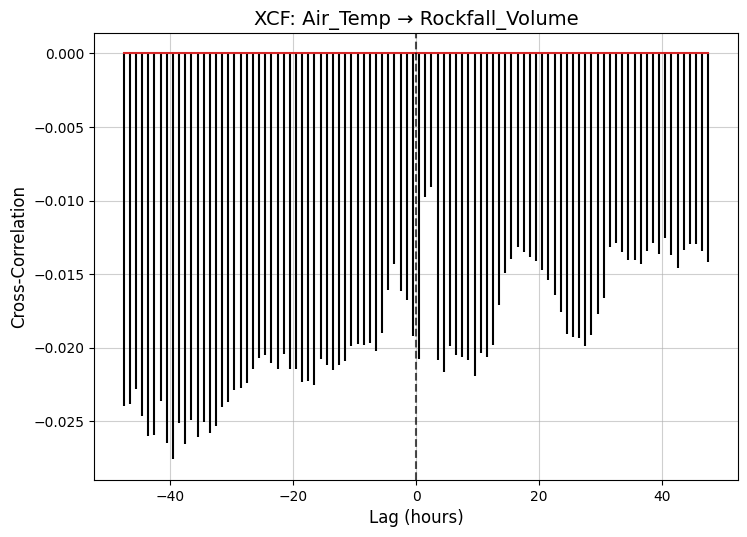


=== XCF: Total_Rainfall → Rockfall_Event_Count ===


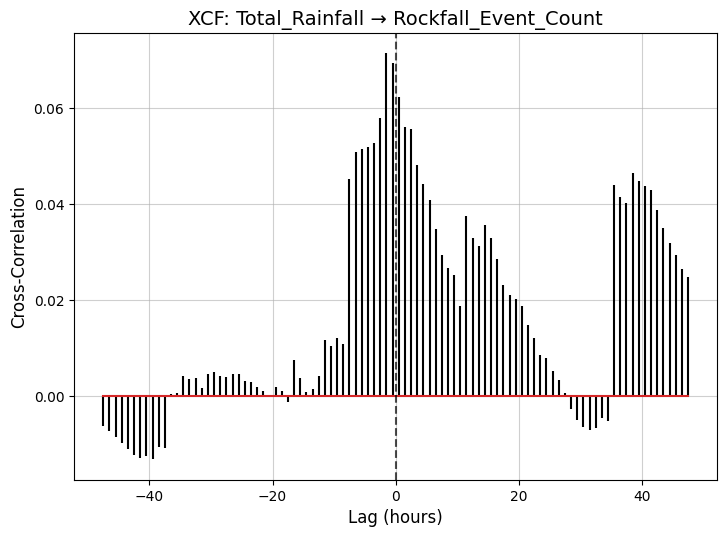


=== XCF: Total_Rainfall → Rockfall_Volume ===


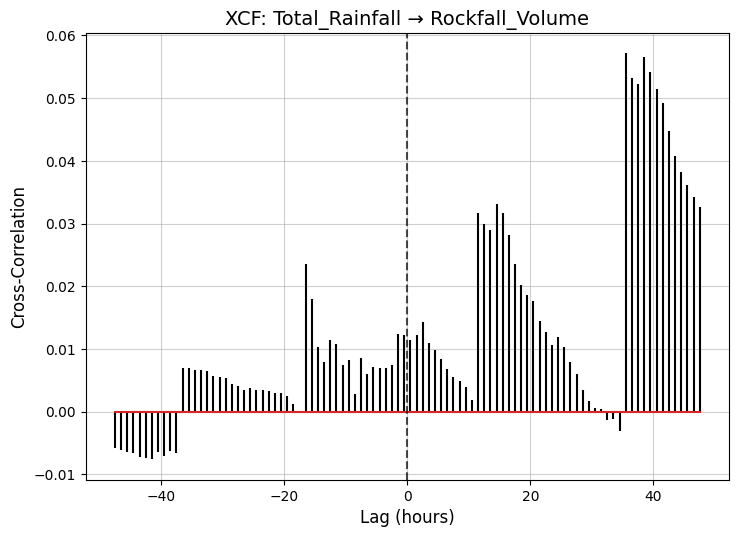


=== XCF: Relative_Humidity → Rockfall_Event_Count ===


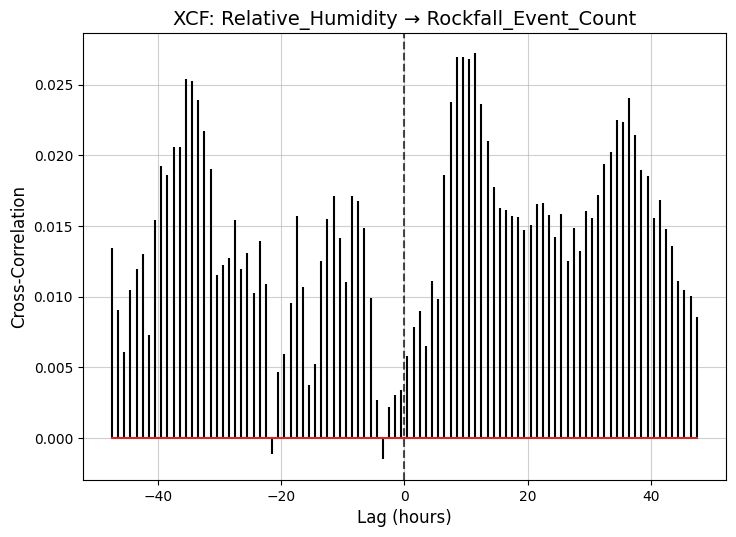


=== XCF: Relative_Humidity → Rockfall_Volume ===


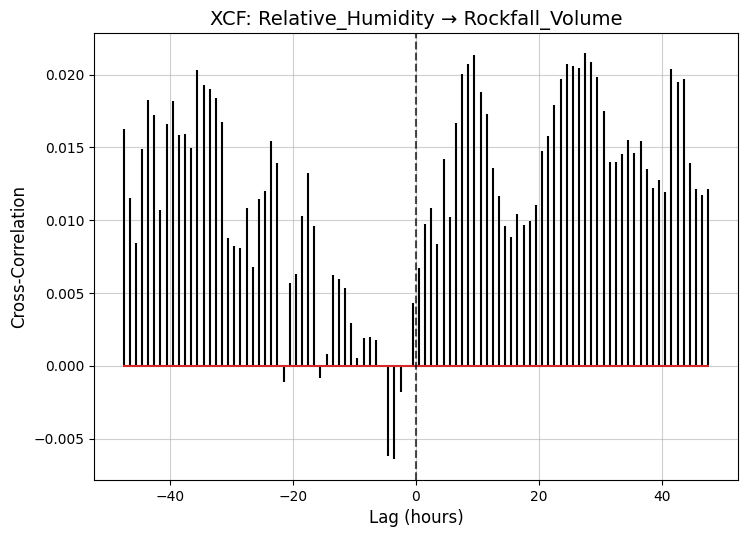


=== XCF: Tmean → Rockfall_Event_Count ===


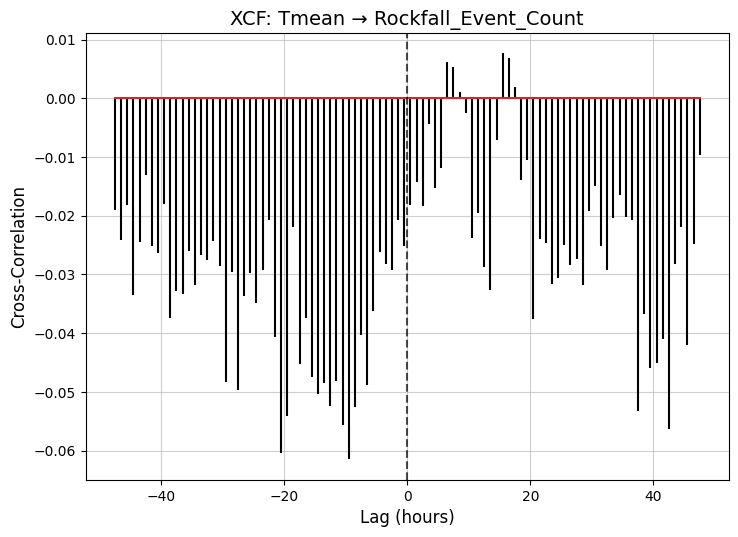


=== XCF: Tmean → Rockfall_Volume ===


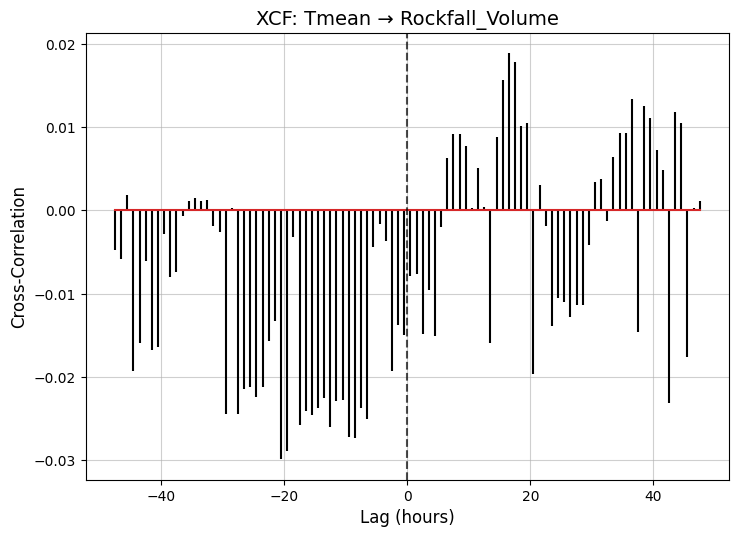


=== XCF: Tmax → Rockfall_Event_Count ===


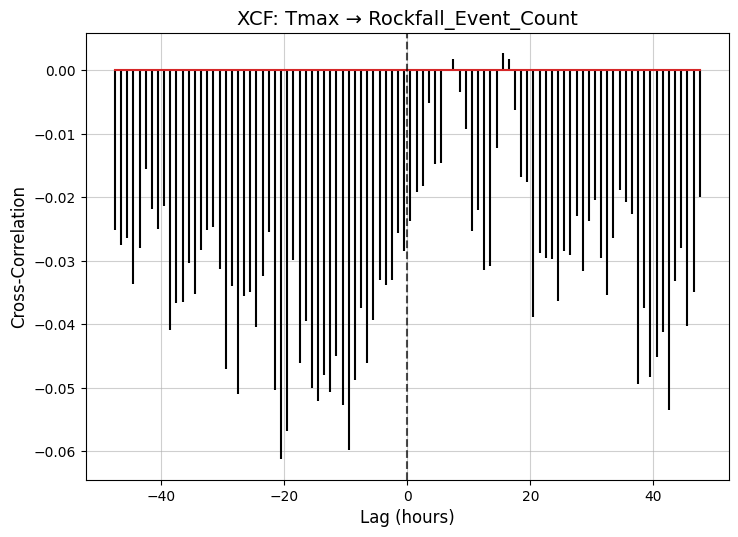


=== XCF: Tmax → Rockfall_Volume ===


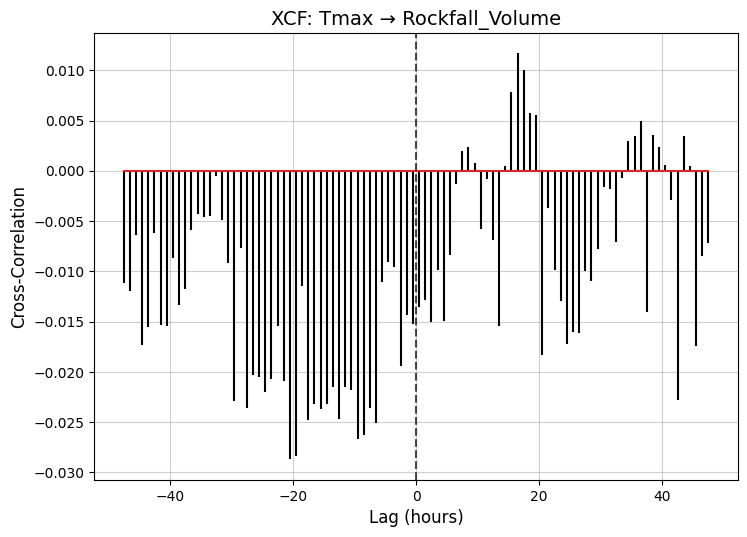


=== XCF: Ref_Mean → Rockfall_Event_Count ===


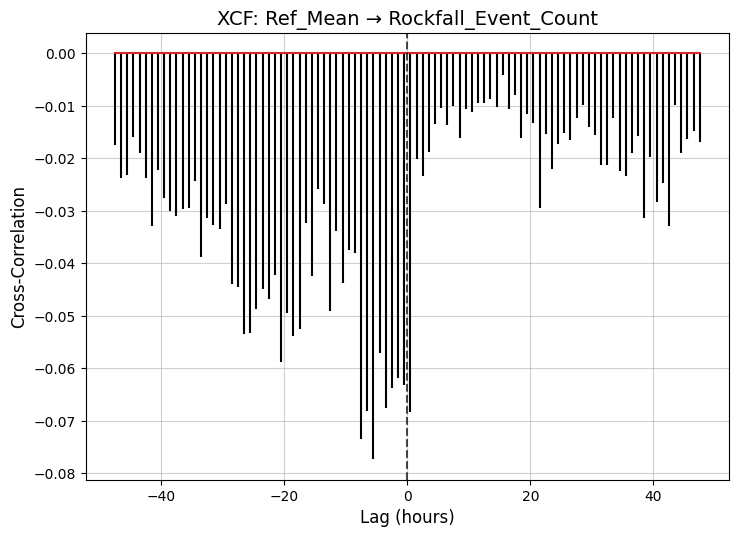


=== XCF: Ref_Mean → Rockfall_Volume ===


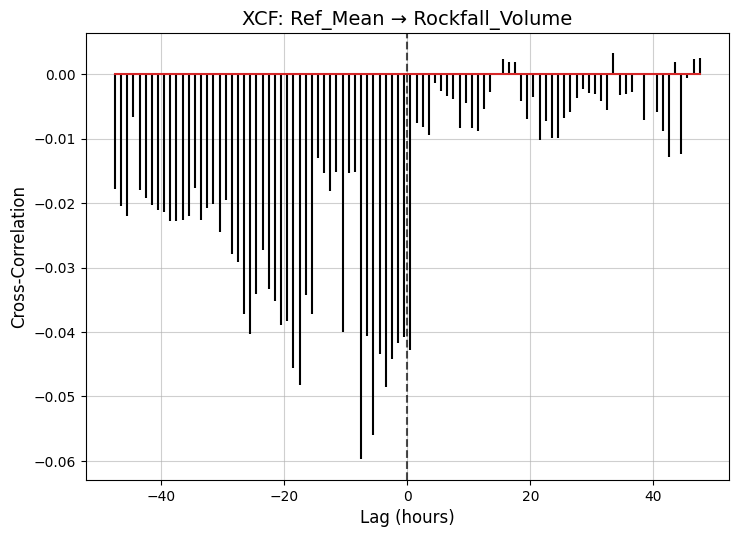


=== XCF: Ref_Max → Rockfall_Event_Count ===


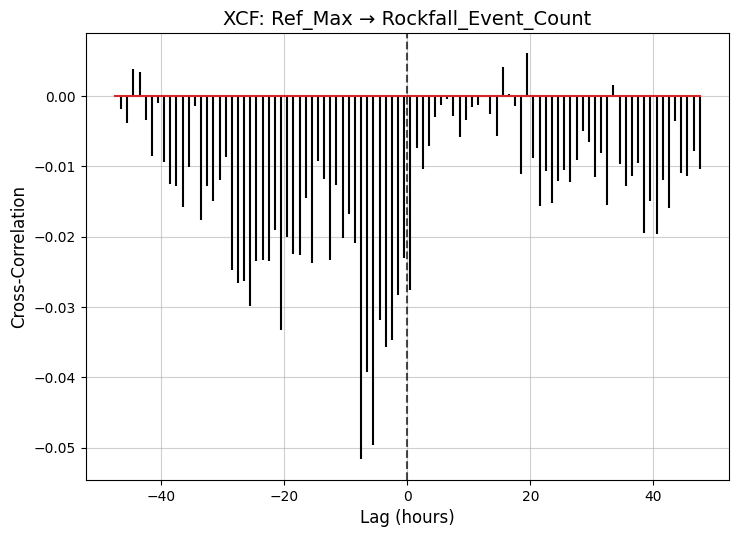


=== XCF: Ref_Max → Rockfall_Volume ===


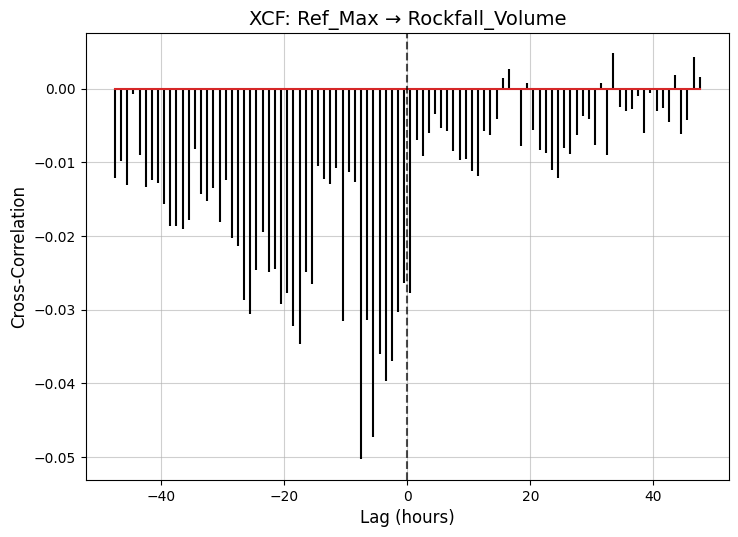

In [25]:
# ============================================================
# Codeblock L — Run Irregular‑Time XCF for All Variables
# ============================================================

environmental_vars = [
    'Hourly_Rainfall',
    'Air_Temp',
    'Total_Rainfall',
    'Relative_Humidity',
    'Tmean',
    'Tmax',
    'Ref_Mean',
    'Ref_Max'
    # Add or remove variables as needed
]

rockfall_targets = [
    'Rockfall_Event_Count',
    'Rockfall_Volume'
]

print("Running irregular‑time cross‑correlation for:")
for x in environmental_vars:
    for y in rockfall_targets:
        print(f" - {x} → {y}")

for x in environmental_vars:
    for y in rockfall_targets:
        print(f"\n=== XCF: {x} → {y} ===")
        plot_time_difference_xcf(
            df_agg,
            x_col=x,
            y_col=y,
            time_col='Datetime',
            max_lag_hours=48,
            bin_width_hours=1
        )

# Compute Composites

These basically take an average 'snapshot' of conditions before rockfall events

In [26]:
# ============================================================
# Codeblock M — Extract Event-Aligned Windows
# ============================================================

import numpy as np
import pandas as pd

def extract_event_windows(df, event_col, value_col, time_col='Datetime',
                          window_hours=96):
    """
    Extracts windows of environmental data before each rockfall event.
    Returns a list of arrays, each representing a pre-event window.
    """

    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    # Identify event timestamps
    event_times = df.loc[df[event_col] == 1, time_col].values

    windows = []

    for event_time in event_times:
        start_time = event_time - np.timedelta64(window_hours, 'h')

        # Extract window
        mask = (df[time_col] >= start_time) & (df[time_col] <= event_time)
        window = df.loc[mask, value_col].values

        # Only keep windows of correct length
        if len(window) == window_hours + 1:
            windows.append(window)

    return np.array(windows)

In [27]:
# ============================================================
# Codeblock N — Compute Event-Aligned Composite
# ============================================================

def compute_composite(windows):
    """
    Computes the mean composite curve from aligned event windows.
    """
    if len(windows) == 0:
        return None

    return np.nanmean(windows, axis=0)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_composite(composite, window_hours=48, value_col="Variable"):
    if composite is None:
        print("No valid event windows found.")
        return

    hours = np.arange(-window_hours, 1)  # -48h to 0h

    plt.figure(figsize=(8.3, 5.8))

    # Black line, slightly thicker for clarity
    plt.plot(hours, composite, color="black", linewidth=2)

    # Zero-hour reference line
    plt.axvline(0, color='k', linestyle='--', alpha=0.7)

    plt.xlabel("Hours Before Event", fontsize=12)
    plt.ylabel(value_col, fontsize=12)
    plt.title(f"Event-Aligned Composite: {value_col}", fontsize=14)
    plt.grid(alpha=0.6)

    plt.show()


=== Event-Aligned Composite for Hourly_Rainfall ===


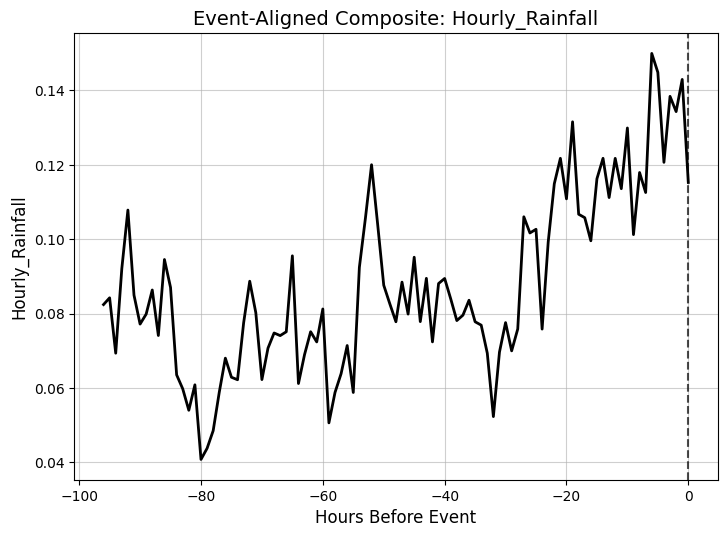


=== Event-Aligned Composite for Air_Temp ===


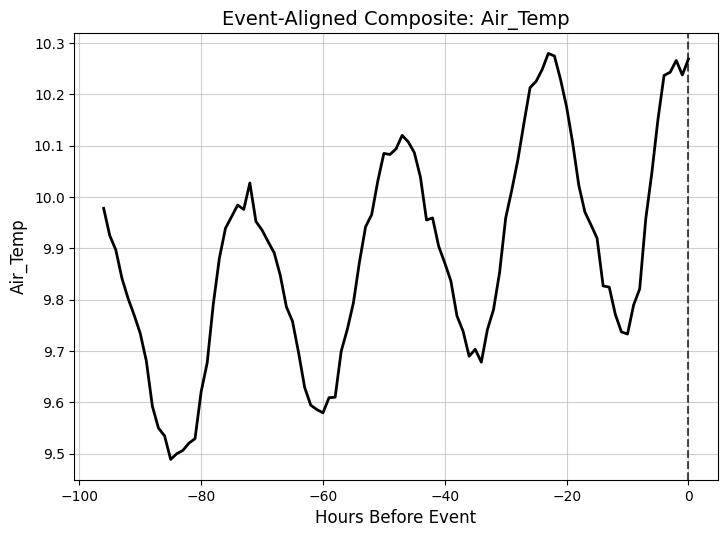


=== Event-Aligned Composite for Total_Rainfall ===


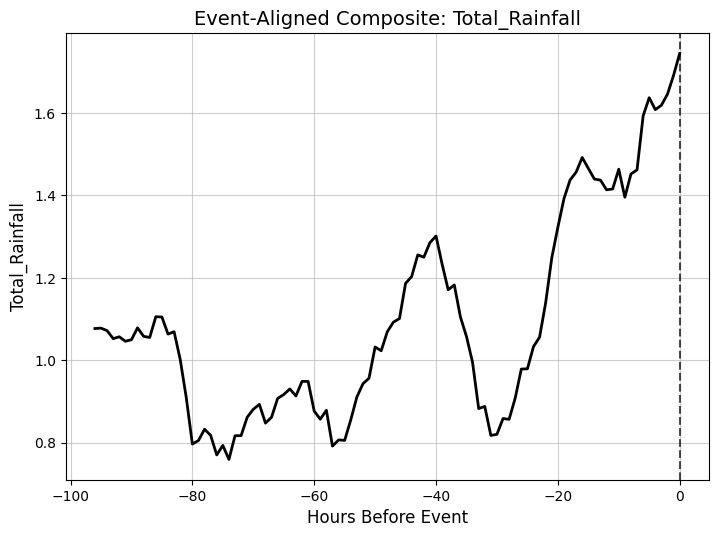


=== Event-Aligned Composite for Relative_Humidity ===


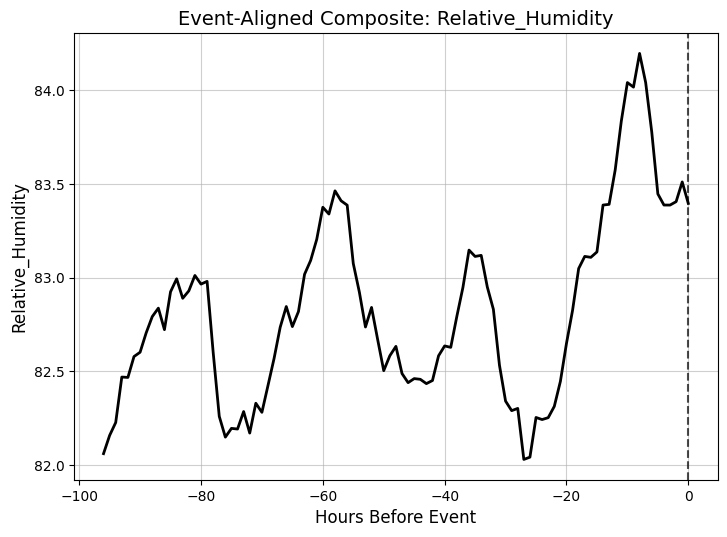


=== Event-Aligned Composite for Tmean ===


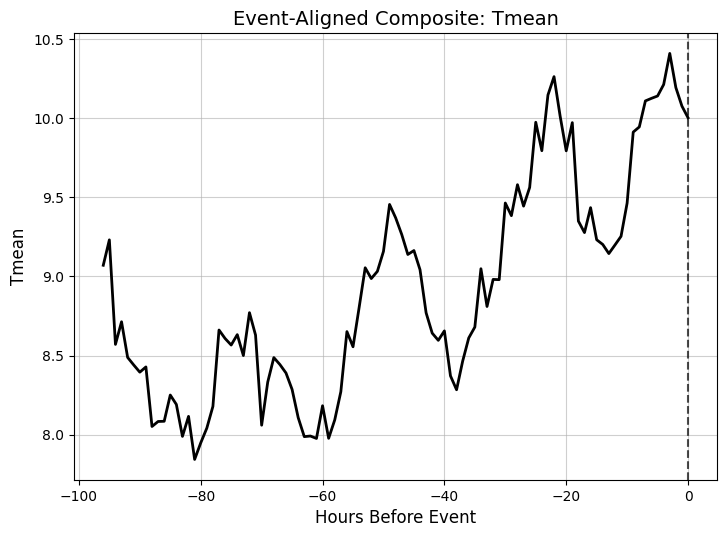


=== Event-Aligned Composite for Tmax ===


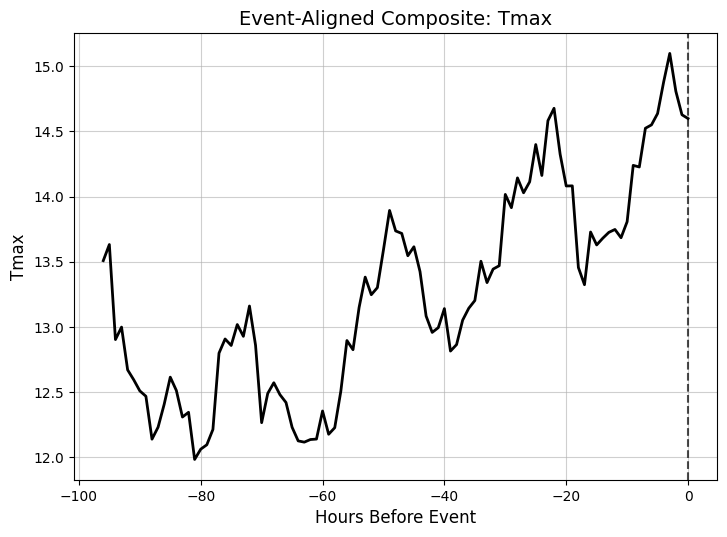


=== Event-Aligned Composite for Ref_Mean ===


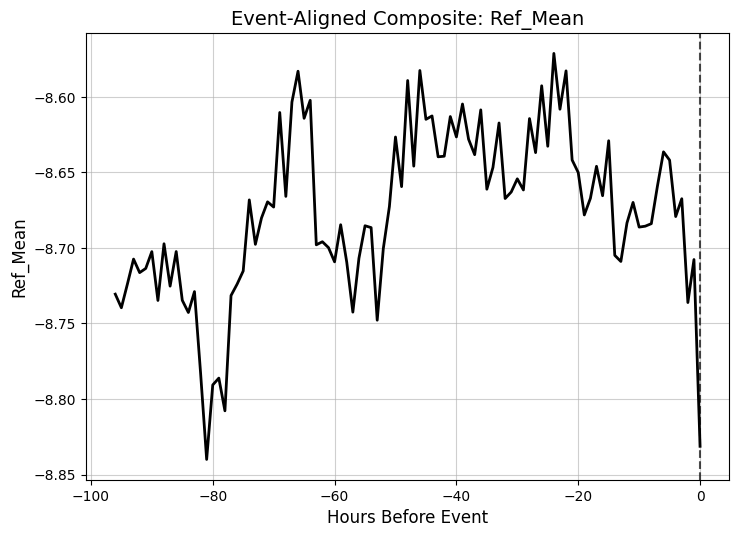


=== Event-Aligned Composite for Ref_Max ===


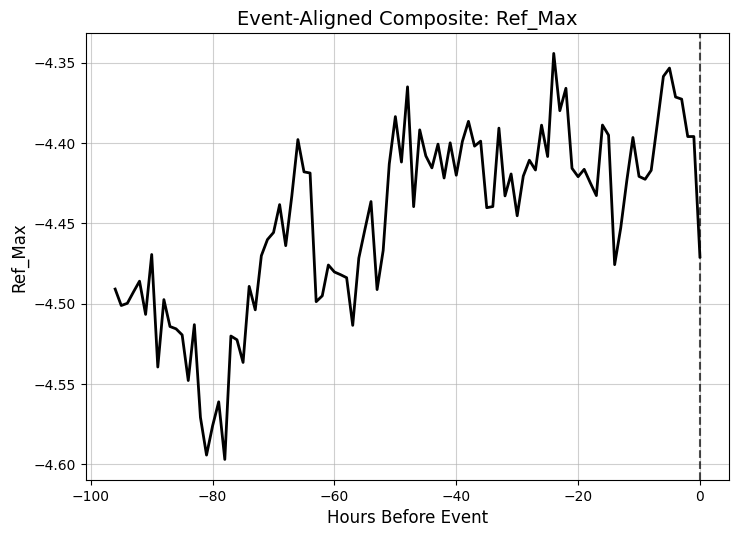

In [29]:
# ============================================================
# Codeblock P — Run Event-Aligned Composites
# ============================================================

environmental_vars = [
    'Hourly_Rainfall',
    'Air_Temp',
    'Total_Rainfall',
    'Relative_Humidity',
    'Tmean',
    'Tmax',
    'Ref_Mean',
    'Ref_Max'
    # Add or remove variables as needed
]

event_col = 'Rockfall_Occurrence'
window_hours = 96

for var in environmental_vars:
    print(f"\n=== Event-Aligned Composite for {var} ===")

    windows = extract_event_windows(
        df_agg,
        event_col=event_col,
        value_col=var,
        time_col='Datetime',
        window_hours=window_hours
    )

    composite = compute_composite(windows)

    plot_composite(
        composite,
        window_hours=window_hours,
        value_col=var
    )